In [1]:
import polars as pl
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
# Load your dataset
df = pl.read_csv('./processed/final_aggregated_rides_example.csv')

# Convert 'Interval' to datetime
df = df.with_columns(
    pl.col("Interval").str.to_datetime().alias("Interval")
)

# Sort by Cluster and Interval
df = df.sort(["Cluster", "Interval"])

In [4]:
df = df.with_columns(
    pl.col("Interval").dt.weekday().alias("DayOfWeek")
)
df = df.with_columns(
    pl.col("Interval").dt.hour().alias("HourOfDay"),
    pl.col("Interval").dt.month().alias("Month"),
    pl.col("Interval").dt.ordinal_day().alias("DayOfYear")
)
df = df.with_columns(
    ((((pl.col("HourOfDay") >= 7) & (pl.col("HourOfDay") < 10) | ((pl.col("HourOfDay") >= 17) & (pl.col("HourOfDay") < 19))) & ((pl.col("DayOfWeek") >= 1) & (pl.col("DayOfWeek") <= 5))) |
     (((pl.col("HourOfDay") >= 13) & (pl.col("HourOfDay") <= 19)) & ((pl.col("DayOfWeek") >= 6) & (pl.col("DayOfWeek") <= 7)))
).cast(pl.Int8).alias("IsPeak"))

In [16]:
# Function to create sequences
def create_sequences(data, seq_length, pred_length):
    """
    Create sequences for multi-step forecasting.
    data: numpy array of shape (num_samples, num_features).
    seq_length: length of the input sequence.
    pred_length: number of steps to predict ahead.
    """
    xs, ys = [], []
    for i in range(len(data) - seq_length - pred_length + 1):
        x = data[i:(i + seq_length)]  # Input sequence
        y = data[(i + seq_length):(i + seq_length + pred_length), :2]  # Targets (Starts and Ends for the next `pred_length` steps)
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Function to split data into training and validation sets
def train_val_split(data, train_ratio=0.8):
    """
    Split data into training and validation sets.
    data: numpy array of shape (num_samples, num_features).
    train_ratio: fraction of data to use for training.
    """
    train_size = int(len(data) * train_ratio)
    train_data = data[:train_size]
    val_data = data[train_size:]
    return train_data, val_data

# Prepare data for each cluster
seq_length = 7 * 48  # 7 days * 48 half-hour intervals per day
pred_length = 48 * 2  # Predict 24 steps (12 hours) ahead
train_ratio = 0.8  # 80% training, 20% validation

clusters_train_data = {}
clusters_val_data = {}
scalers = {}

for cluster in df["Cluster"].unique():
    # Select relevant columns: Starts, Ends, DayOfWeek, HourOfDay, Month, DayOfYear, IsPeak
    cluster_data = df.filter(pl.col("Cluster") == cluster).select(
        ["Starts", "Ends", "DayOfWeek", "HourOfDay", "Month", "DayOfYear", "IsPeak"]
    ).to_numpy()
    
    # Normalize the data
    scaler = MinMaxScaler()
    cluster_data_normalized = scaler.fit_transform(cluster_data)
    scalers[cluster] = scaler  # Save the scaler for this cluster
    
    # Split into training and validation sets
    train_data, val_data = train_val_split(cluster_data_normalized, train_ratio)
    
    # Create sequences for training and validation
    X_train, y_train = create_sequences(train_data, seq_length, pred_length)
    X_val, y_val = create_sequences(val_data, seq_length, pred_length)
    
    clusters_train_data[cluster] = (X_train, y_train)
    clusters_val_data[cluster] = (X_val, y_val)

# Custom Dataset class
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create datasets and dataloaders for each cluster
dataloaders = {}
for cluster, (X, y) in clusters_train_data.items():
    dataset = TimeSeriesDataset(X, y)
    dataloaders[cluster] = DataLoader(dataset, batch_size=32, shuffle=True)

Something is wrong, since during prediction I don't give to the model values of features from y timepoints (day of the week, day in year, peak and so on)

In [17]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        
        # Additional linear layer
        self.fc1 = nn.Linear(hidden_size, hidden_size)  # First linear layer
        self.fc2 = nn.Linear(hidden_size, output_size)  # Final output layer

    def forward(self, x):
        # Initialize hidden state and cell state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # LSTM forward pass
        out, _ = self.lstm(x, (h0, c0))  # out shape: (batch_size, seq_length, hidden_size)
        
        # Take the output of the last time step
        out = out[:, -1, :]  # out shape: (batch_size, hidden_size)
        
        # Pass through the first linear layer
        out = self.fc1(out)  # out shape: (batch_size, hidden_size)
        
        # Pass through the final linear layer (no activation function)
        out = self.fc2(out)  # out shape: (batch_size, output_size)
        
        return out

In [18]:
# Hyperparameters
input_size = 7  # Starts and Ends
hidden_size = 128
output_size = 2 * pred_length  # Predict Starts and Ends
num_layers = 1

# Initialize the model
model = LSTMModel(input_size=input_size, hidden_size=hidden_size, output_size=output_size, num_layers=num_layers).to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

c:\Users\huber\anaconda3\envs\torch-cuda\lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


In [19]:
# Training function
def train_model(dataloader, model, criterion, optimizer, num_epochs=10):
    model.train()
    losses = []
    for epoch in range(num_epochs):
        epoch_loss = 0
        for batch_X, batch_y in dataloader:
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)
            
            # Forward pass
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y.view(batch_y.size(0), -1))  # Flatten batch_y
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
            optimizer.step()
            
            epoch_loss += loss.item()
        
        epoch_loss /= len(dataloader)
        losses.append(epoch_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')
    
    # Plot loss
    import matplotlib.pyplot as plt
    plt.plot(losses)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.show()

Training for Cluster 0
Epoch [1/20], Loss: 0.0108
Epoch [2/20], Loss: 0.0049
Epoch [3/20], Loss: 0.0040
Epoch [4/20], Loss: 0.0036
Epoch [5/20], Loss: 0.0035
Epoch [6/20], Loss: 0.0034
Epoch [7/20], Loss: 0.0033
Epoch [8/20], Loss: 0.0032
Epoch [9/20], Loss: 0.0031
Epoch [10/20], Loss: 0.0031
Epoch [11/20], Loss: 0.0030
Epoch [12/20], Loss: 0.0042
Epoch [13/20], Loss: 0.0030
Epoch [14/20], Loss: 0.0028
Epoch [15/20], Loss: 0.0031
Epoch [16/20], Loss: 0.0030
Epoch [17/20], Loss: 0.0031
Epoch [18/20], Loss: 0.0029
Epoch [19/20], Loss: 0.0030
Epoch [20/20], Loss: 0.0031


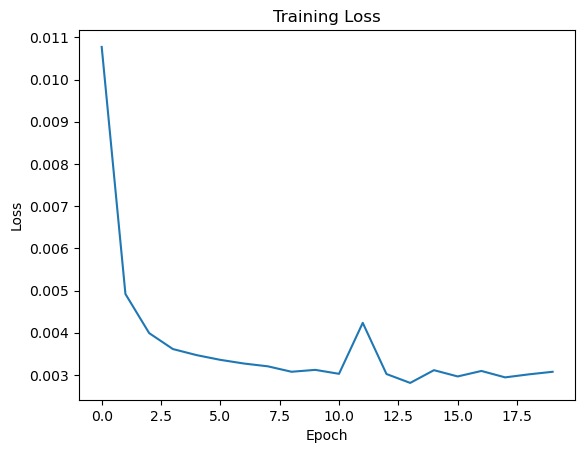

In [20]:
# Train for each cluster
for cluster, (X_train, y_train) in clusters_train_data.items():
    # Create DataLoader for training data
    train_dataset = TimeSeriesDataset(X_train, y_train)
    train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    
    print(f'Training for Cluster {cluster}')
    train_model(train_dataloader, model, criterion, optimizer, num_epochs=20)

# Prediction

In [21]:
def inverse_transform_predictions(predictions, cluster):
    """
    Inverse transform predictions using the scaler for the given cluster.
    predictions: numpy array of shape (num_samples, 2) containing predictions for Starts and Ends.
    cluster: the cluster ID to retrieve the corresponding scaler.
    """
    # Reshape predictions to match the scaler's expected input shape
    predictions = predictions.reshape(-1, 2)  # Ensure predictions are in shape (num_samples, 2)
    
    # Create a dummy array for the other features (excluding Starts and Ends)
    num_samples = predictions.shape[0]
    num_features = scalers[cluster].n_features_in_  # Total number of features used during fitting
    dummy_features = np.zeros((num_samples, num_features - 2))  # Exclude Starts and Ends
    
    # Combine predictions and dummy features
    combined = np.hstack([predictions, dummy_features])
    
    # Inverse transform the combined array
    original_scale_predictions = scalers[cluster].inverse_transform(combined)
    
    # Extract only the Starts and Ends columns
    original_scale_predictions = original_scale_predictions[:, :2]
    
    return original_scale_predictions

In [22]:
# Example: Make predictions for cluster 0 on the validation set
cluster = 0
val_X, val_y = clusters_val_data[cluster]

# Create DataLoader for validation data
val_dataset = TimeSeriesDataset(val_X, val_y)
val_dataloader = DataLoader(val_dataset, batch_size=48, shuffle=False)
iter_val_dataloader = iter(val_dataloader)
model.eval()

LSTMModel(
  (lstm): LSTM(7, 128, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=128, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=192, bias=True)
)

In [23]:
with torch.no_grad():
    # Get a batch of validation data
    batch_X, batch_y = next(iter_val_dataloader)
    batch_X = batch_X.to(device)
    
    # Make predictions
    predictions = model(batch_X).cpu().numpy()
    
    # Reshape predictions to (batch_size, pred_length, 2)
    predictions = predictions.reshape(-1, pred_length, 2)
    
    # Inverse transform predictions
    original_scale_predictions = []
    for i in range(predictions.shape[0]):
        pred = inverse_transform_predictions(predictions[i], cluster)
        original_scale_predictions.append(pred)
    original_scale_predictions = np.array(original_scale_predictions)
    
    # Inverse transform the true values (batch_y)
    original_scale_true = []
    for i in range(batch_y.shape[0]):
        true = inverse_transform_predictions(batch_y[i].numpy(), cluster)
        original_scale_true.append(true)
    original_scale_true = np.array(original_scale_true)
    
    # Print results
    print("Predictions (original scale):")
    print(original_scale_predictions)
    print("True values (original scale):")
    print(original_scale_true)

Predictions (original scale):
[[[ 1.69553977 -5.86882798]
  [ 3.49402499 -1.28541348]
  [ 4.79078841  4.54402925]
  ...
  [25.96291058 14.68710764]
  [21.36828823 15.19616334]
  [17.41264679 13.51270398]]

 [[-2.03491414 -9.1895775 ]
  [ 1.71659148 -2.6202201 ]
  [ 4.42854203  6.87259585]
  ...
  [24.59041862 15.46880934]
  [22.00608334 15.84490559]
  [20.50821719 16.72371826]]

 [[ 3.20473731 -1.82071826]
  [ 5.88366351  2.3515116 ]
  [ 9.30123319 11.55322215]
  ...
  [22.03295599 13.30298027]
  [21.73568954 14.33975533]
  [22.49826707 20.34959871]]

 ...

 [[41.03248641 14.81903166]
  [30.92593326 11.06837309]
  [20.73918292  8.03317564]
  ...
  [46.62923831 38.43722689]
  [46.43132168 33.22640189]
  [43.81087494 29.69311321]]

 [[29.81815366  8.0073273 ]
  [21.57850602  8.16263194]
  [15.44094627  6.23971216]
  ...
  [45.26645768 33.09146981]
  [45.06672749 30.00007457]
  [39.04710543 25.81091325]]

 [[23.45453784 11.6799354 ]
  [12.76091528  7.14895183]
  [10.76987311  5.54596929]


In [24]:
# Extract true and predicted values for Starts and Ends
true_starts = original_scale_true[:, :, 0]  # Shape: (batch_size, pred_length)
true_ends = original_scale_true[:, :, 1]    # Shape: (batch_size, pred_length)
pred_starts = original_scale_predictions[:, :, 0]  # Shape: (batch_size, pred_length)
pred_ends = original_scale_predictions[:, :, 1]    # Shape: (batch_size, pred_length)

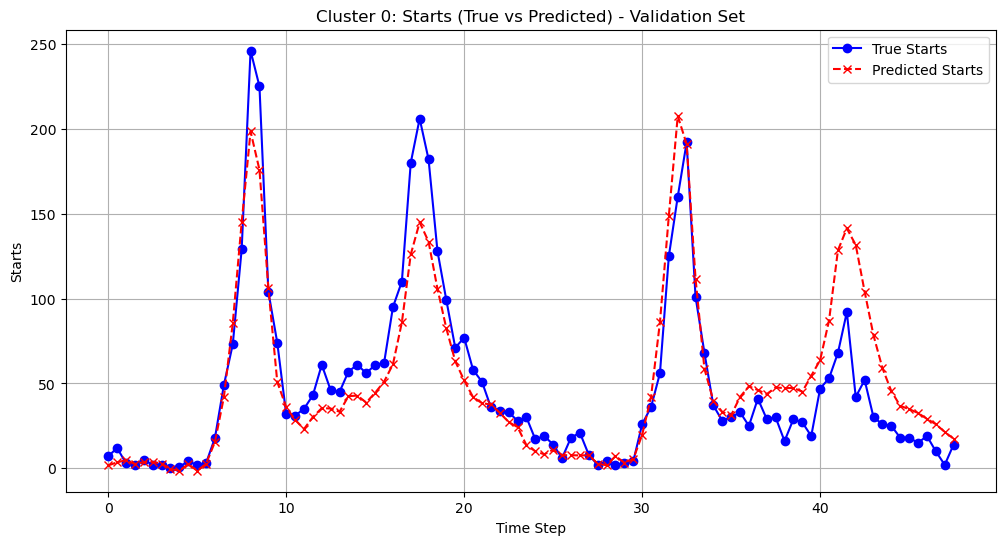

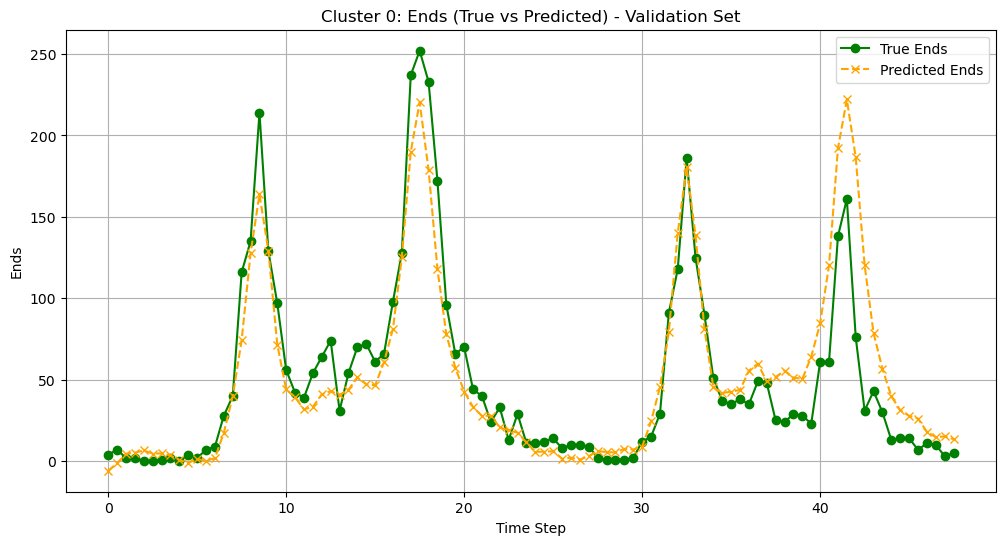

In [25]:
index = 0

# Plot Starts for the first sample in the batch
plt.figure(figsize=(12, 6))
plt.plot(np.linspace(0, pred_length/2 - 0.5, pred_length), true_starts[index], label="True Starts", color="blue", marker="o")
plt.plot(np.linspace(0, pred_length/2 - 0.5, pred_length), pred_starts[index], label="Predicted Starts", color="red", linestyle="--", marker="x")
plt.title(f"Cluster {cluster}: Starts (True vs Predicted) - Validation Set")
plt.xlabel("Time Step")
plt.ylabel("Starts")
plt.legend()
plt.grid(True)
plt.show()

# Plot Ends for the first sample in the batch
plt.figure(figsize=(12, 6))
plt.plot(np.linspace(0, pred_length/2 - 0.5, pred_length), true_ends[index], label="True Ends", color="green", marker="o")
plt.plot(np.linspace(0, pred_length/2 - 0.5, pred_length), pred_ends[index], label="Predicted Ends", color="orange", linestyle="--", marker="x")
plt.title(f"Cluster {cluster}: Ends (True vs Predicted) - Validation Set")
plt.xlabel("Time Step")
plt.ylabel("Ends")
plt.legend()
plt.grid(True)
plt.show()